In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

import itertools
from kernels import HMC_our, HMC_vanilla
from target import GMM_target, GMM_target2
from args import get_args

import matplotlib
matplotlib.rcParams.update({'font.size': 20})

# import pdb

In [2]:
args = get_args()

In [3]:
target = GMM_target2(args)

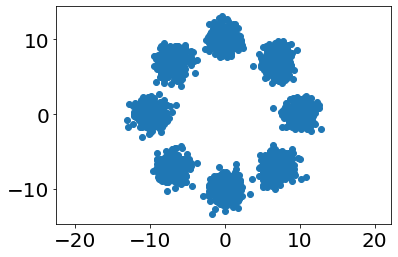

In [4]:
target_samples = target.get_samples(n=3000).cpu().numpy()
plt.scatter(target_samples[:, 0], target_samples[:, 1])
plt.axis('equal');

#### Common setup

In [5]:
args.n_steps = 1000 # how many samples to use
args.n_warmup = 1000 # num of first samples to refuse

args.n_chains = 10 # how many chains to model

In [6]:
q_init = args.std_normal.sample((args.n_chains, args.z_dim))
p_init = args.std_normal.sample((args.n_chains, args.z_dim))

#### Vanilla HMC

In [7]:
vanilla_kernel = HMC_vanilla(args)

In [8]:
q_new = q_init
p_new = p_init

print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup))
for i in iterator:
    q_new, p_new, _, _, a = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()
    
samples_vanilla = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)
print("Now we are sampling!")

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
    samples_vanilla[i] = q_new
iterator.close()

  0%|          | 4/1000 [00:00<00:25, 39.08it/s]

Now we are running warmup!


  0%|          | 4/1000 [00:00<00:25, 39.20it/s]

Now we are sampling!


100%|██████████| 1000/1000 [00:26<00:00, 38.00it/s]


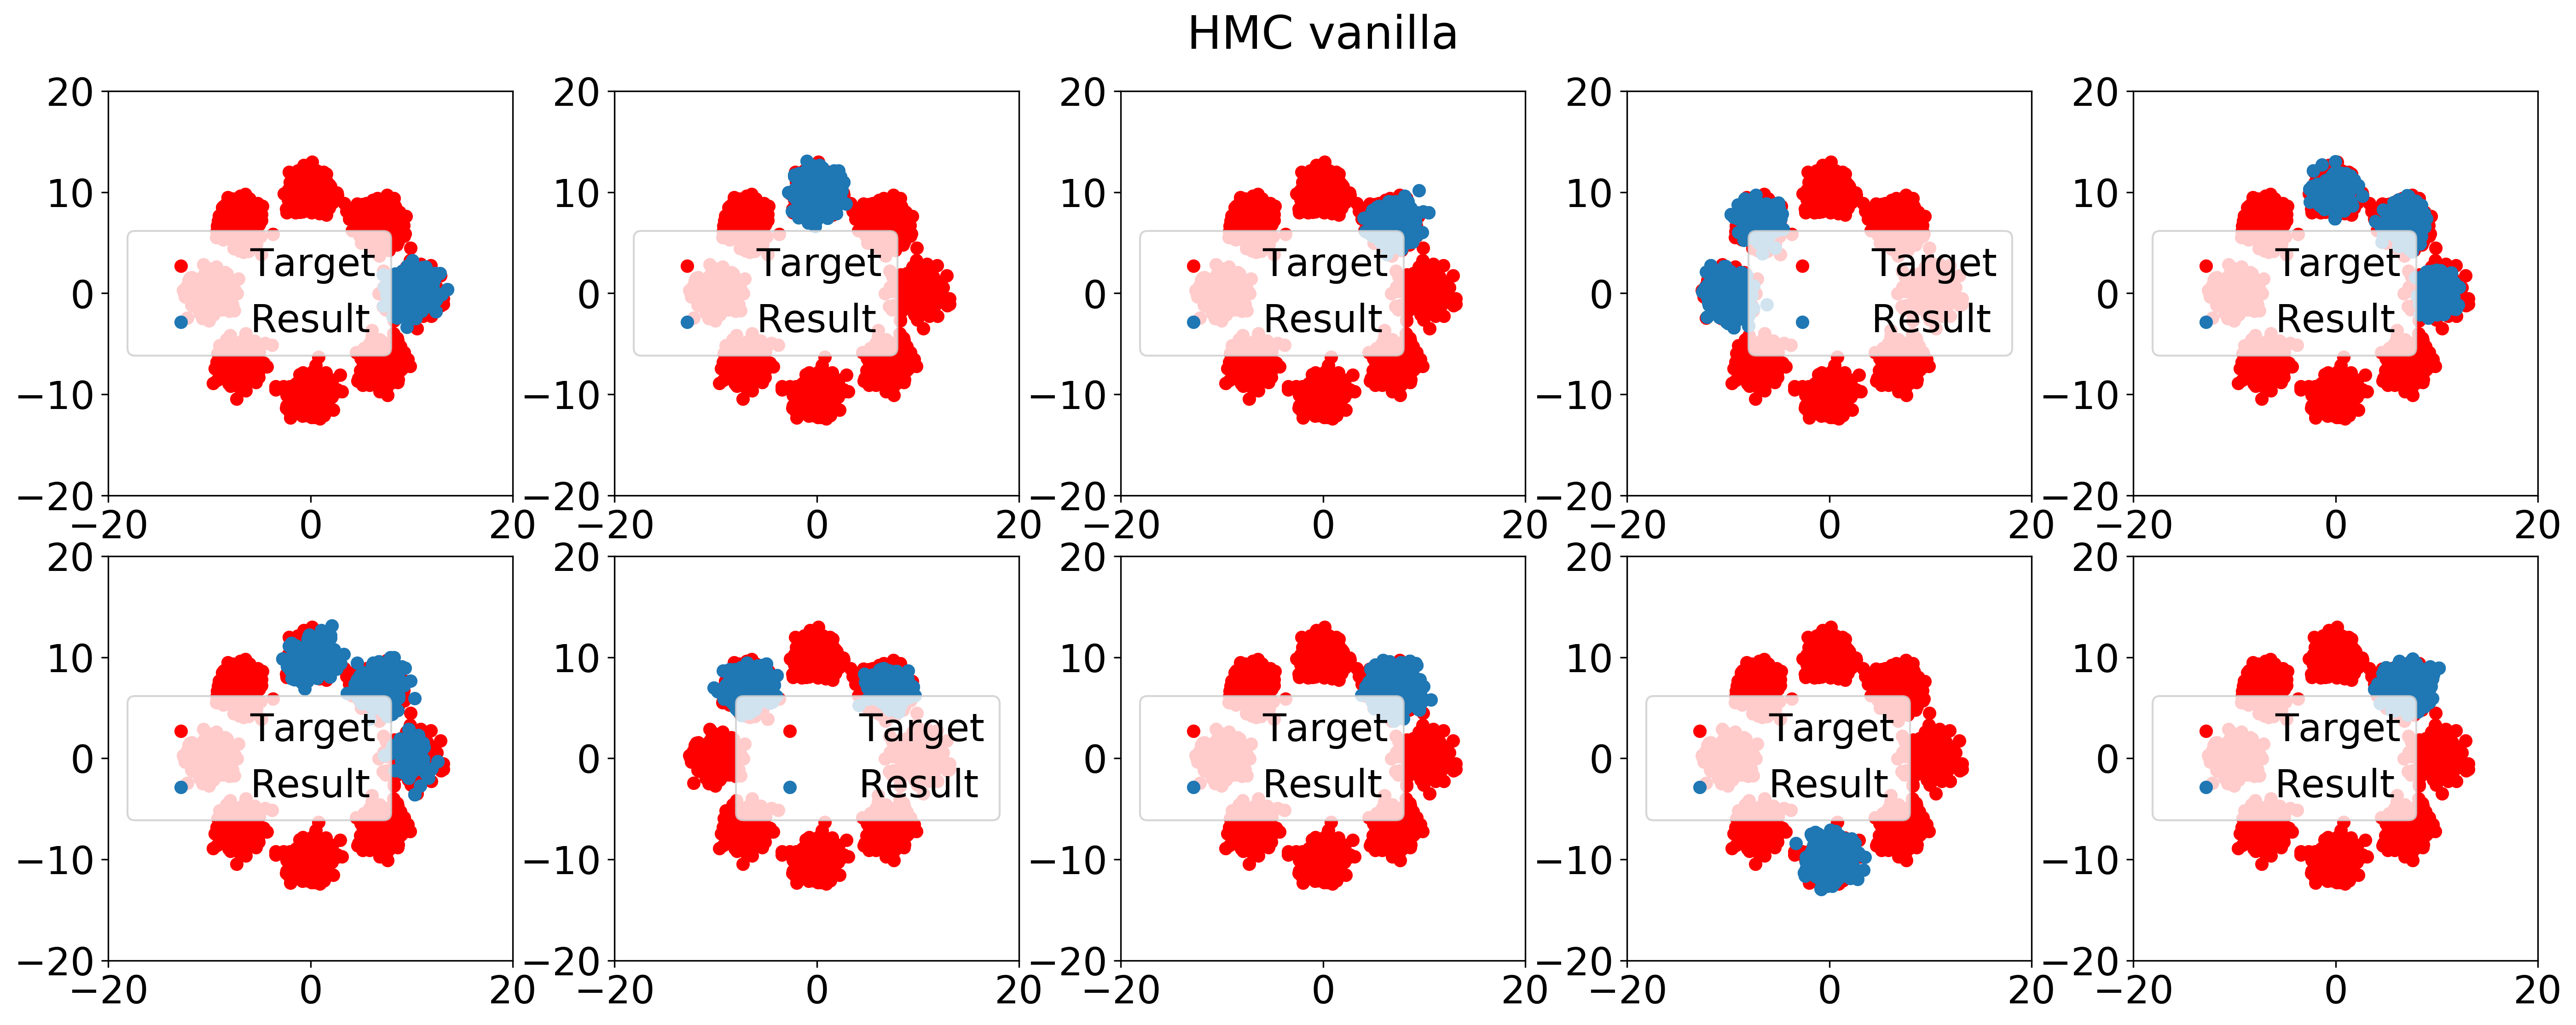

In [9]:
limit = 20
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC vanilla')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_vanilla[:, chain_num, 0].cpu(), samples_vanilla[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

#### Ours HMC

In [7]:
transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])
our_kernel = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])

optimizer = torch.optim.Adam(params=transitions.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=200)

##### Training

  0%|          | 0/10000 [00:00<?, ?it/s]

On batch number 0 and on k = 1 we have for 0: 0.066 and for +1: 0.934
Step size for 0-th transition is 1.0
Alpha (ref) for 0-th transition is 0.5
On batch number 0 and on k = 2 we have for 0: 0.676 and for +1: 0.324
Step size for 1-th transition is 1.0
Alpha (ref) for 1-th transition is 0.5
On batch number 0 and on k = 3 we have for 0: 0.326 and for +1: 0.674
Step size for 2-th transition is 1.0
Alpha (ref) for 2-th transition is 0.5
On batch number 0 and on k = 4 we have for 0: 0.49 and for +1: 0.51
Step size for 3-th transition is 1.0
Alpha (ref) for 3-th transition is 0.5
On batch number 0 and on k = 5 we have for 0: 0.37 and for +1: 0.63
Step size for 4-th transition is 1.0
Alpha (ref) for 4-th transition is 0.5


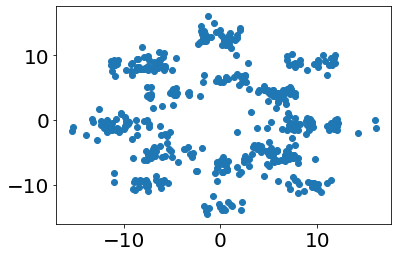

Current lr:  0.1
On batch number 0 ELBO is -16.649906158447266
On batch number 0 Best ELBO is -inf


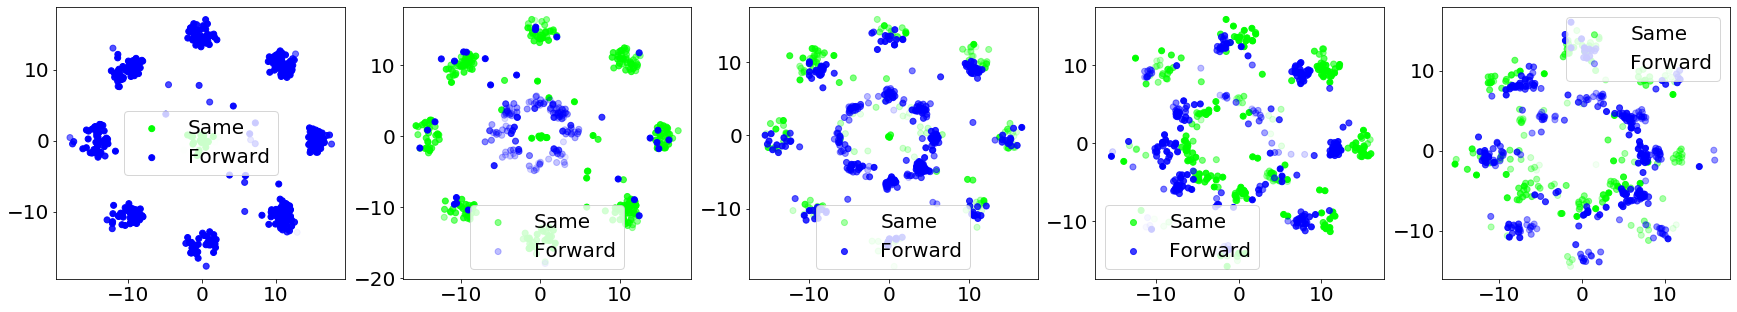

  1%|          | 100/10000 [00:20<32:17,  5.11it/s]

On batch number 100 and on k = 1 we have for 0: 0.464 and for +1: 0.536
Step size for 0-th transition is 0.07106120884418488
Alpha (ref) for 0-th transition is 0.4433037340641022
On batch number 100 and on k = 2 we have for 0: 1.0 and for +1: 0.0
Step size for 1-th transition is 3.281085252761841
Alpha (ref) for 1-th transition is 0.4658134877681732
On batch number 100 and on k = 3 we have for 0: 0.49 and for +1: 0.51
Step size for 2-th transition is 0.04274420812726021
Alpha (ref) for 2-th transition is 0.7231718897819519
On batch number 100 and on k = 4 we have for 0: 0.492 and for +1: 0.508
Step size for 3-th transition is 0.04110126197338104
Alpha (ref) for 3-th transition is 0.5319754481315613
On batch number 100 and on k = 5 we have for 0: 0.484 and for +1: 0.516
Step size for 4-th transition is 0.06093955785036087
Alpha (ref) for 4-th transition is 0.39547139406204224


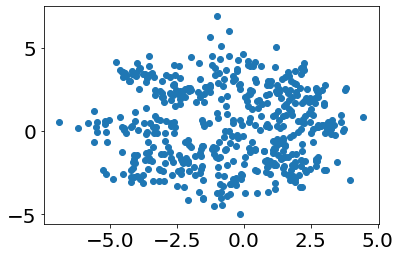

Current lr:  0.1
On batch number 100 ELBO is -37.875083923339844
On batch number 100 Best ELBO is -13.626323699951172


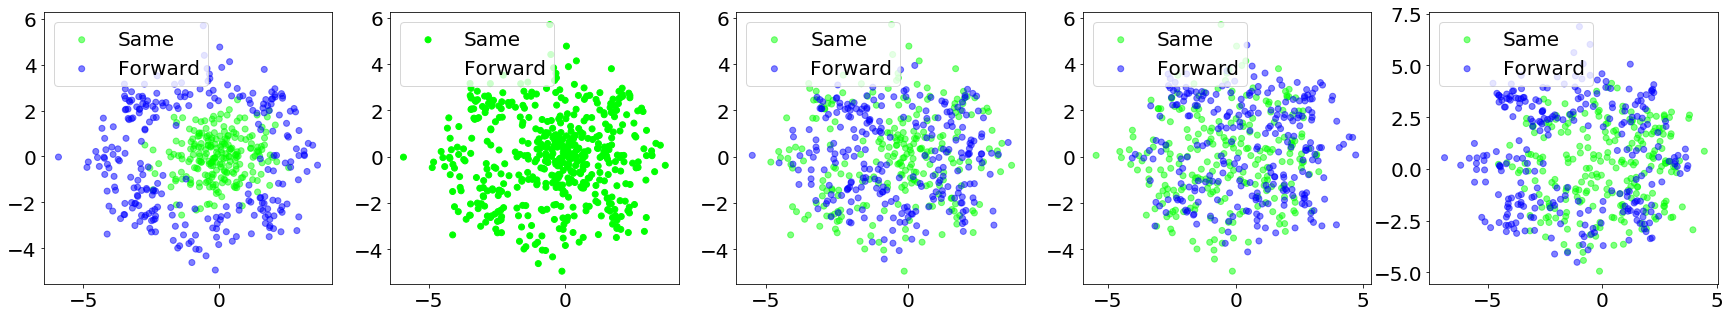

  2%|▏         | 200/10000 [00:41<31:18,  5.22it/s]  

On batch number 200 and on k = 1 we have for 0: 0.462 and for +1: 0.538
Step size for 0-th transition is 0.028208130970597267
Alpha (ref) for 0-th transition is 0.6546056866645813
On batch number 200 and on k = 2 we have for 0: 1.0 and for +1: 0.0
Step size for 1-th transition is 3.281454563140869
Alpha (ref) for 1-th transition is 0.5889414548873901
On batch number 200 and on k = 3 we have for 0: 0.49 and for +1: 0.51
Step size for 2-th transition is 0.0729726180434227
Alpha (ref) for 2-th transition is 0.8030261397361755
On batch number 200 and on k = 4 we have for 0: 0.536 and for +1: 0.464
Step size for 3-th transition is 0.03794354945421219
Alpha (ref) for 3-th transition is 0.6326054930686951
On batch number 200 and on k = 5 we have for 0: 0.464 and for +1: 0.536
Step size for 4-th transition is 0.05663704127073288
Alpha (ref) for 4-th transition is 0.6767309308052063


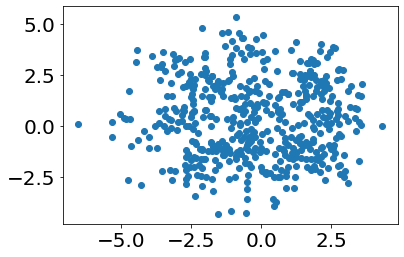

Current lr:  0.1
On batch number 200 ELBO is -38.56077575683594
On batch number 200 Best ELBO is -13.626323699951172


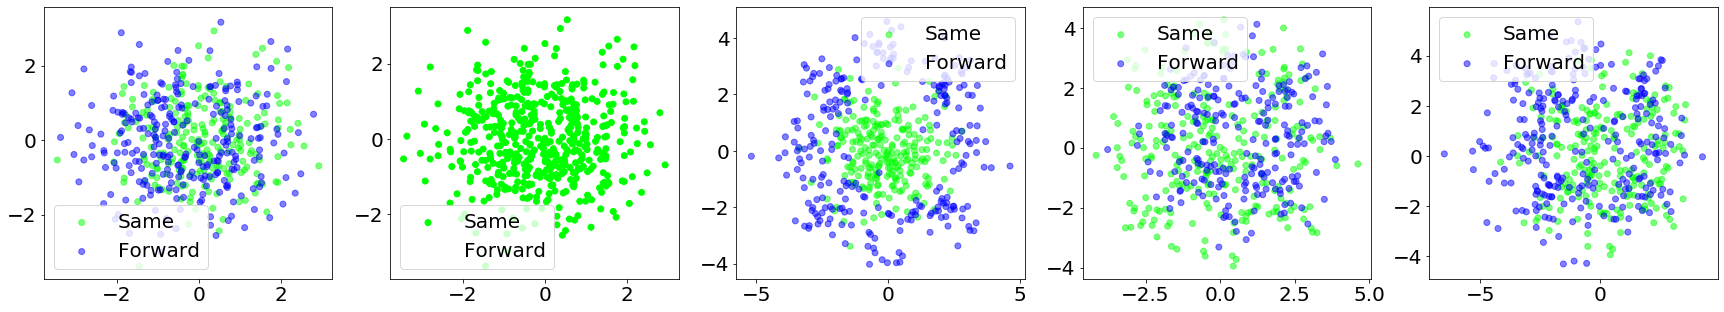

  3%|▎         | 300/10000 [01:02<33:16,  4.86it/s]  

On batch number 300 and on k = 1 we have for 0: 0.486 and for +1: 0.514
Step size for 0-th transition is 0.028759129345417023
Alpha (ref) for 0-th transition is 0.7057063579559326
On batch number 300 and on k = 2 we have for 0: 1.0 and for +1: 0.0
Step size for 1-th transition is 3.281454563140869
Alpha (ref) for 1-th transition is 0.6182222366333008
On batch number 300 and on k = 3 we have for 0: 0.486 and for +1: 0.514
Step size for 2-th transition is 0.07350365072488785
Alpha (ref) for 2-th transition is 0.820306122303009
On batch number 300 and on k = 4 we have for 0: 0.488 and for +1: 0.512
Step size for 3-th transition is 0.038160912692546844
Alpha (ref) for 3-th transition is 0.6270517706871033
On batch number 300 and on k = 5 we have for 0: 0.448 and for +1: 0.552
Step size for 4-th transition is 0.05665740743279457
Alpha (ref) for 4-th transition is 0.6873993873596191


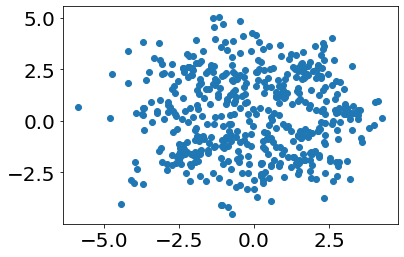

Current lr:  0.010000000000000002
On batch number 300 ELBO is -37.97735595703125
On batch number 300 Best ELBO is -13.626323699951172


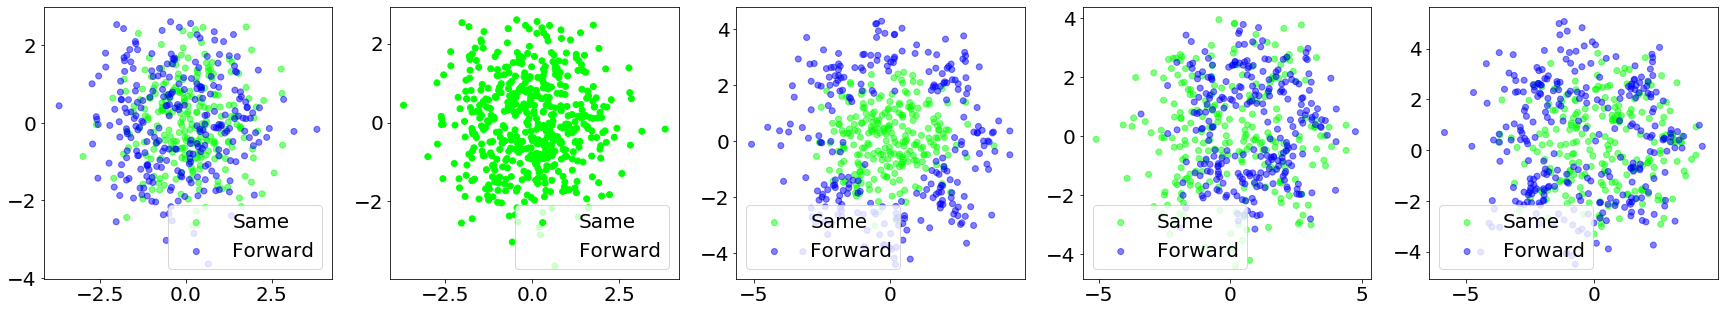

  4%|▍         | 400/10000 [01:22<31:26,  5.09it/s]  

On batch number 400 and on k = 1 we have for 0: 0.514 and for +1: 0.486
Step size for 0-th transition is 0.029012586921453476
Alpha (ref) for 0-th transition is 0.7223379015922546
On batch number 400 and on k = 2 we have for 0: 1.0 and for +1: 0.0
Step size for 1-th transition is 3.281454563140869
Alpha (ref) for 1-th transition is 0.6290149092674255
On batch number 400 and on k = 3 we have for 0: 0.516 and for +1: 0.484
Step size for 2-th transition is 0.07373522967100143
Alpha (ref) for 2-th transition is 0.8261067271232605
On batch number 400 and on k = 4 we have for 0: 0.47 and for +1: 0.53
Step size for 3-th transition is 0.0385696142911911
Alpha (ref) for 3-th transition is 0.62273770570755
On batch number 400 and on k = 5 we have for 0: 0.466 and for +1: 0.534
Step size for 4-th transition is 0.0554751455783844
Alpha (ref) for 4-th transition is 0.6768086552619934


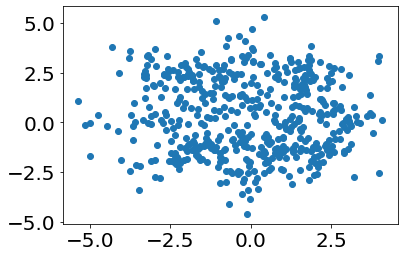

Current lr:  0.010000000000000002
On batch number 400 ELBO is -38.833778381347656
On batch number 400 Best ELBO is -13.626323699951172


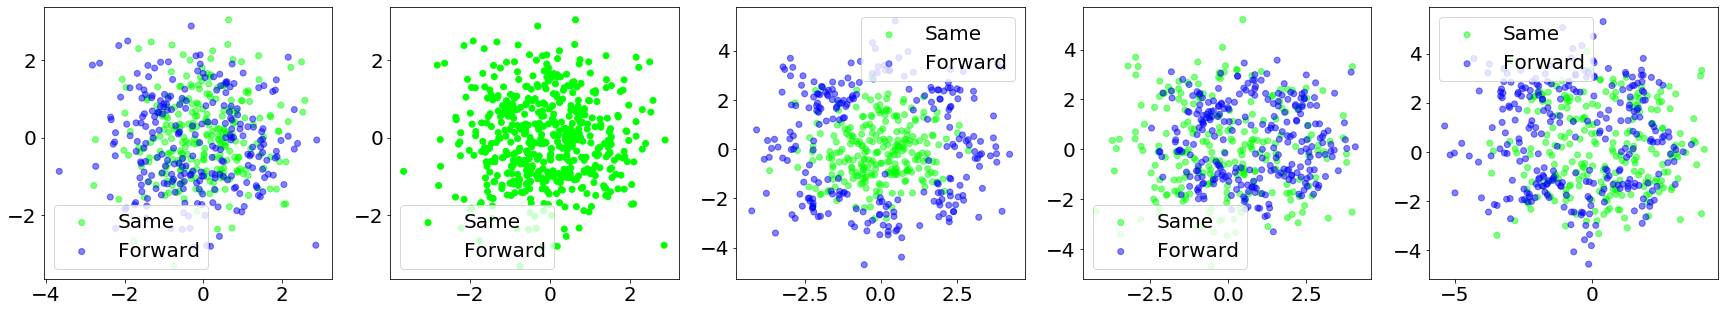

  5%|▌         | 500/10000 [01:43<30:57,  5.11it/s]

On batch number 500 and on k = 1 we have for 0: 0.486 and for +1: 0.514
Step size for 0-th transition is 0.029097480699419975
Alpha (ref) for 0-th transition is 0.727493166923523
On batch number 500 and on k = 2 we have for 0: 1.0 and for +1: 0.0
Step size for 1-th transition is 3.281454563140869
Alpha (ref) for 1-th transition is 0.6317266821861267
On batch number 500 and on k = 3 we have for 0: 0.534 and for +1: 0.466
Step size for 2-th transition is 0.07347868382930756
Alpha (ref) for 2-th transition is 0.8276354074478149
On batch number 500 and on k = 4 we have for 0: 0.512 and for +1: 0.488
Step size for 3-th transition is 0.03871365636587143
Alpha (ref) for 3-th transition is 0.6216295957565308
On batch number 500 and on k = 5 we have for 0: 0.466 and for +1: 0.534
Step size for 4-th transition is 0.05504658445715904
Alpha (ref) for 4-th transition is 0.6737627983093262


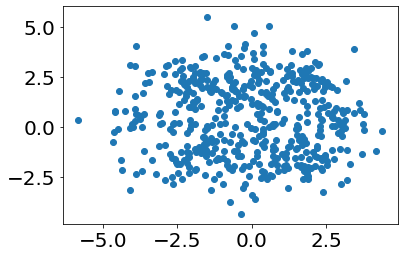

Current lr:  0.0010000000000000002
On batch number 500 ELBO is -38.4552001953125
On batch number 500 Best ELBO is -13.626323699951172


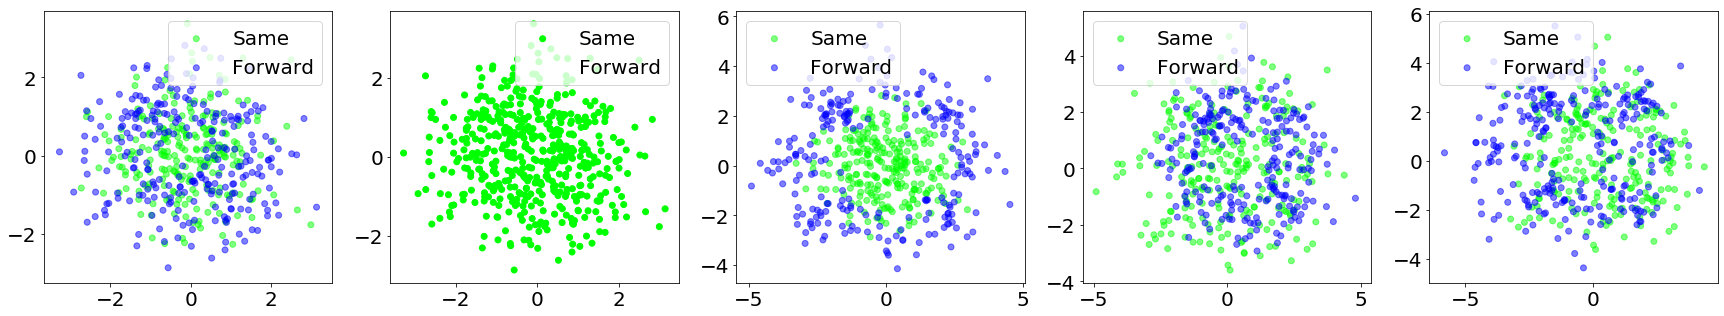

  6%|▌         | 600/10000 [02:03<36:47,  4.26it/s]  

On batch number 600 and on k = 1 we have for 0: 0.532 and for +1: 0.468
Step size for 0-th transition is 0.02913515456020832
Alpha (ref) for 0-th transition is 0.7297093868255615
On batch number 600 and on k = 2 we have for 0: 1.0 and for +1: 0.0
Step size for 1-th transition is 3.281454563140869
Alpha (ref) for 1-th transition is 0.6332187652587891
On batch number 600 and on k = 3 we have for 0: 0.464 and for +1: 0.536
Step size for 2-th transition is 0.07340925186872482
Alpha (ref) for 2-th transition is 0.8285525441169739
On batch number 600 and on k = 4 we have for 0: 0.516 and for +1: 0.484
Step size for 3-th transition is 0.03874821960926056
Alpha (ref) for 3-th transition is 0.6213015913963318
On batch number 600 and on k = 5 we have for 0: 0.52 and for +1: 0.48
Step size for 4-th transition is 0.05490952730178833
Alpha (ref) for 4-th transition is 0.6731624007225037


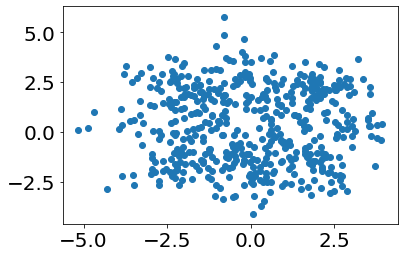

Current lr:  0.0010000000000000002
On batch number 600 ELBO is -37.78047561645508
On batch number 600 Best ELBO is -13.626323699951172


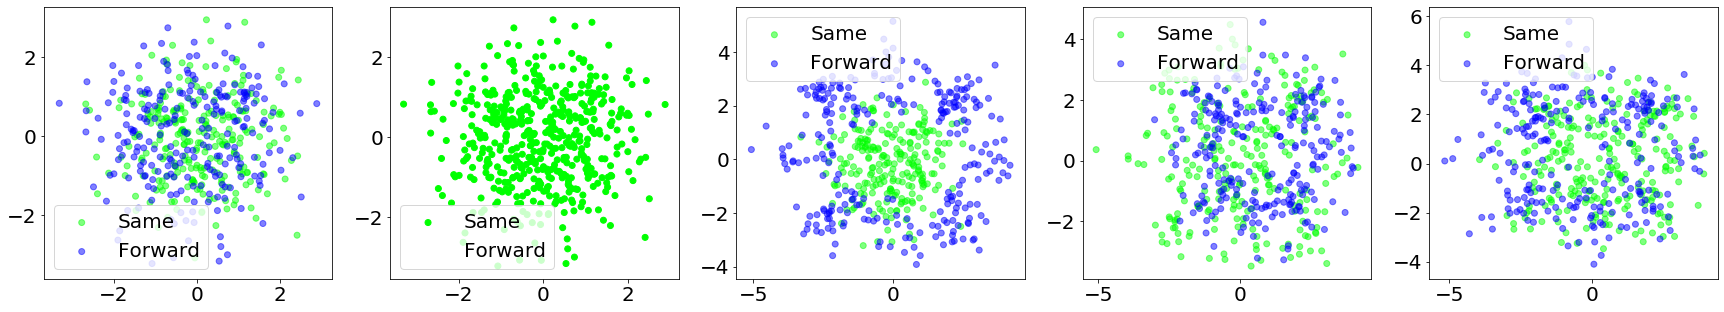

  7%|▋         | 700/10000 [02:24<34:33,  4.48it/s]  

On batch number 700 and on k = 1 we have for 0: 0.46 and for +1: 0.54
Step size for 0-th transition is 0.02914561703801155
Alpha (ref) for 0-th transition is 0.7303141951560974
On batch number 700 and on k = 2 we have for 0: 1.0 and for +1: 0.0
Step size for 1-th transition is 3.281454563140869
Alpha (ref) for 1-th transition is 0.6336116790771484
On batch number 700 and on k = 3 we have for 0: 0.528 and for +1: 0.472
Step size for 2-th transition is 0.07338792085647583
Alpha (ref) for 2-th transition is 0.8287724852561951
On batch number 700 and on k = 4 we have for 0: 0.508 and for +1: 0.492
Step size for 3-th transition is 0.03875579684972763
Alpha (ref) for 3-th transition is 0.6212457418441772
On batch number 700 and on k = 5 we have for 0: 0.522 and for +1: 0.478
Step size for 4-th transition is 0.054857973009347916
Alpha (ref) for 4-th transition is 0.6731336116790771


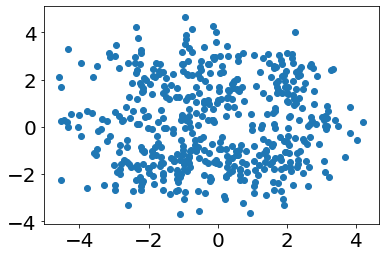

Current lr:  0.00010000000000000003
On batch number 700 ELBO is -38.2268180847168
On batch number 700 Best ELBO is -13.626323699951172


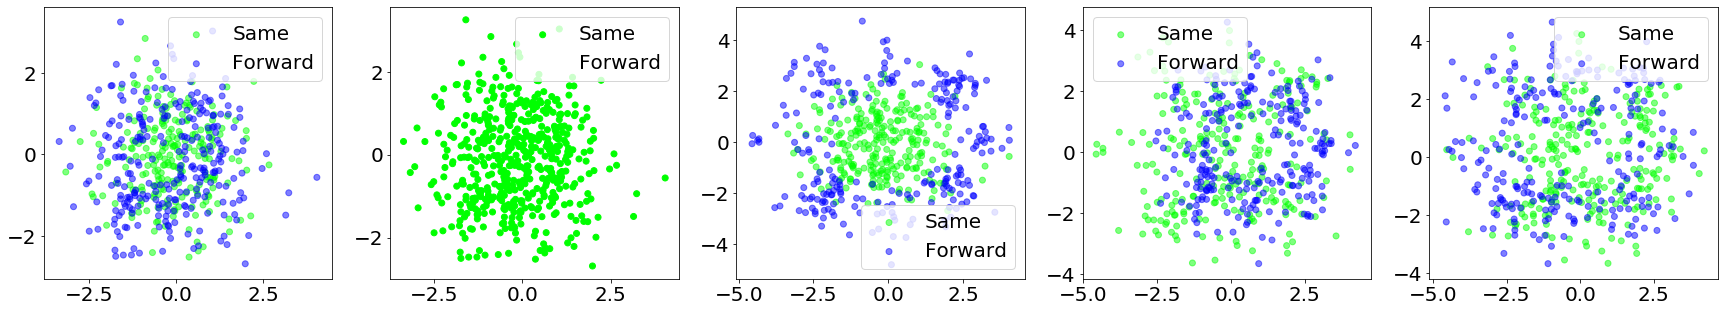

  8%|▊         | 800/10000 [02:45<29:07,  5.26it/s]  

On batch number 800 and on k = 1 we have for 0: 0.504 and for +1: 0.496
Step size for 0-th transition is 0.029149940237402916
Alpha (ref) for 0-th transition is 0.7305653095245361
On batch number 800 and on k = 2 we have for 0: 1.0 and for +1: 0.0
Step size for 1-th transition is 3.281454563140869
Alpha (ref) for 1-th transition is 0.6337340474128723
On batch number 800 and on k = 3 we have for 0: 0.5 and for +1: 0.5
Step size for 2-th transition is 0.07339299470186234
Alpha (ref) for 2-th transition is 0.8288514018058777
On batch number 800 and on k = 4 we have for 0: 0.478 and for +1: 0.522
Step size for 3-th transition is 0.03875979036092758
Alpha (ref) for 3-th transition is 0.621203601360321
On batch number 800 and on k = 5 we have for 0: 0.504 and for +1: 0.496
Step size for 4-th transition is 0.05484865978360176
Alpha (ref) for 4-th transition is 0.673075258731842


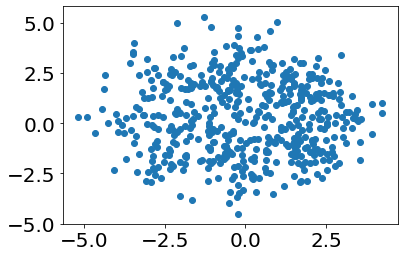

Current lr:  0.00010000000000000003
On batch number 800 ELBO is -38.4145622253418
On batch number 800 Best ELBO is -13.626323699951172


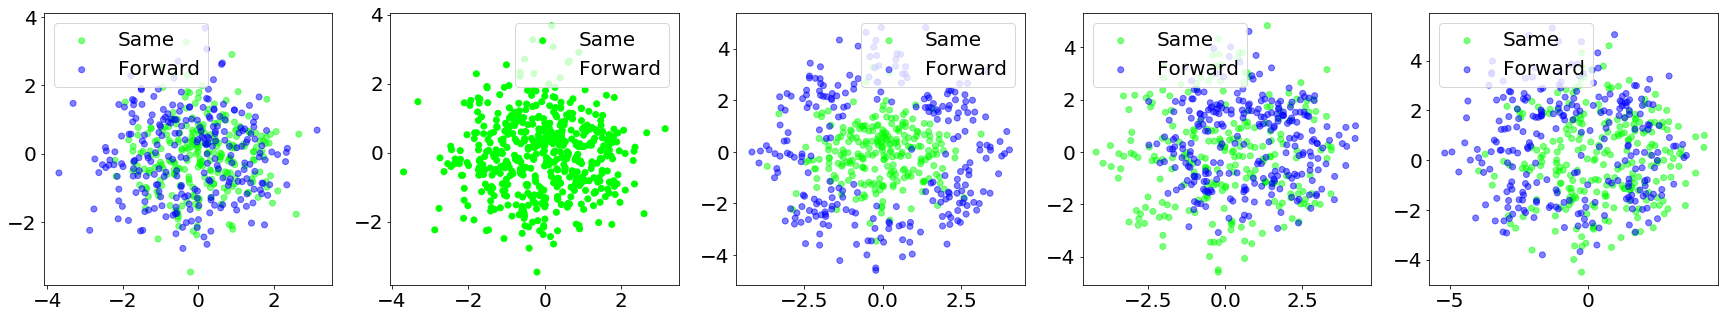

  9%|▉         | 900/10000 [03:06<30:50,  4.92it/s]

On batch number 900 and on k = 1 we have for 0: 0.52 and for +1: 0.48
Step size for 0-th transition is 0.02915148437023163
Alpha (ref) for 0-th transition is 0.7306435704231262
On batch number 900 and on k = 2 we have for 0: 1.0 and for +1: 0.0
Step size for 1-th transition is 3.281454563140869
Alpha (ref) for 1-th transition is 0.6337761878967285
On batch number 900 and on k = 3 we have for 0: 0.498 and for +1: 0.502
Step size for 2-th transition is 0.07339069992303848
Alpha (ref) for 2-th transition is 0.8288825750350952
On batch number 900 and on k = 4 we have for 0: 0.456 and for +1: 0.544
Step size for 3-th transition is 0.03876173123717308
Alpha (ref) for 3-th transition is 0.6211775541305542
On batch number 900 and on k = 5 we have for 0: 0.494 and for +1: 0.506
Step size for 4-th transition is 0.05483940243721008
Alpha (ref) for 4-th transition is 0.6730660796165466


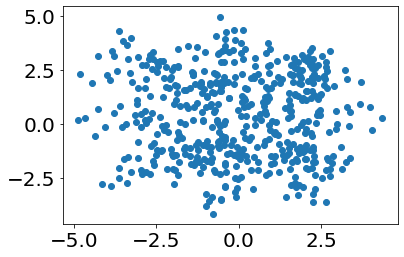

Current lr:  1.0000000000000004e-05
On batch number 900 ELBO is -38.26447296142578
On batch number 900 Best ELBO is -13.626323699951172


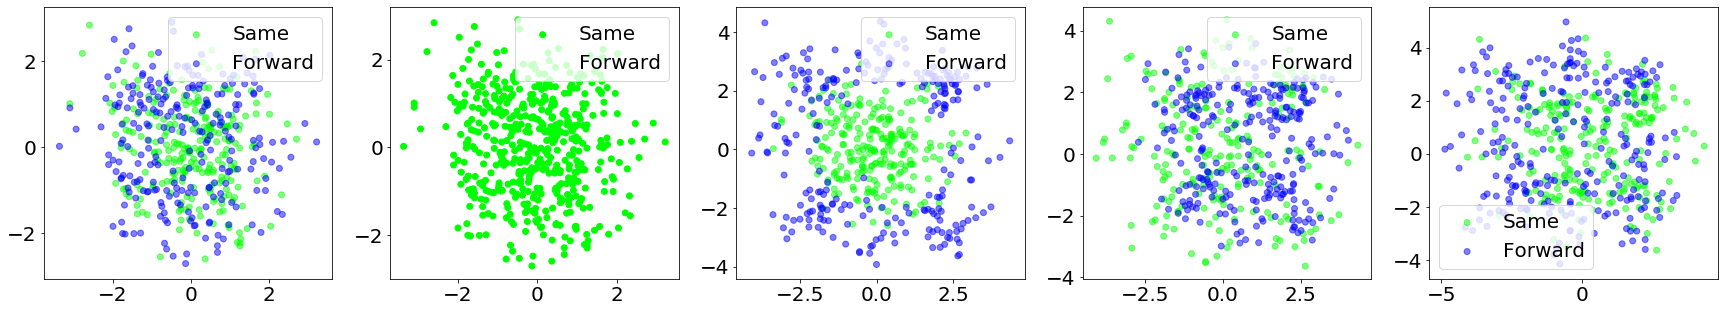

 10%|█         | 1000/10000 [03:26<28:44,  5.22it/s] 

On batch number 1000 and on k = 1 we have for 0: 0.512 and for +1: 0.488
Step size for 0-th transition is 0.02915217913687229
Alpha (ref) for 0-th transition is 0.7306704521179199
On batch number 1000 and on k = 2 we have for 0: 1.0 and for +1: 0.0
Step size for 1-th transition is 3.281454563140869
Alpha (ref) for 1-th transition is 0.6337966322898865
On batch number 1000 and on k = 3 we have for 0: 0.526 and for +1: 0.474
Step size for 2-th transition is 0.07338989526033401
Alpha (ref) for 2-th transition is 0.8288927674293518
On batch number 1000 and on k = 4 we have for 0: 0.472 and for +1: 0.528
Step size for 3-th transition is 0.0387621633708477
Alpha (ref) for 3-th transition is 0.6211738586425781
On batch number 1000 and on k = 5 we have for 0: 0.5 and for +1: 0.5
Step size for 4-th transition is 0.05483732372522354
Alpha (ref) for 4-th transition is 0.6730614900588989


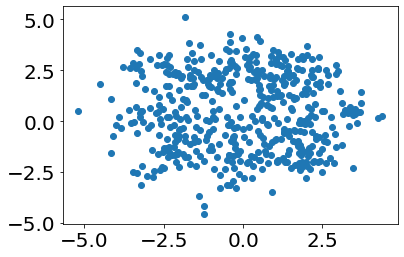

Current lr:  1.0000000000000004e-05
On batch number 1000 ELBO is -38.261138916015625
On batch number 1000 Best ELBO is -13.626323699951172


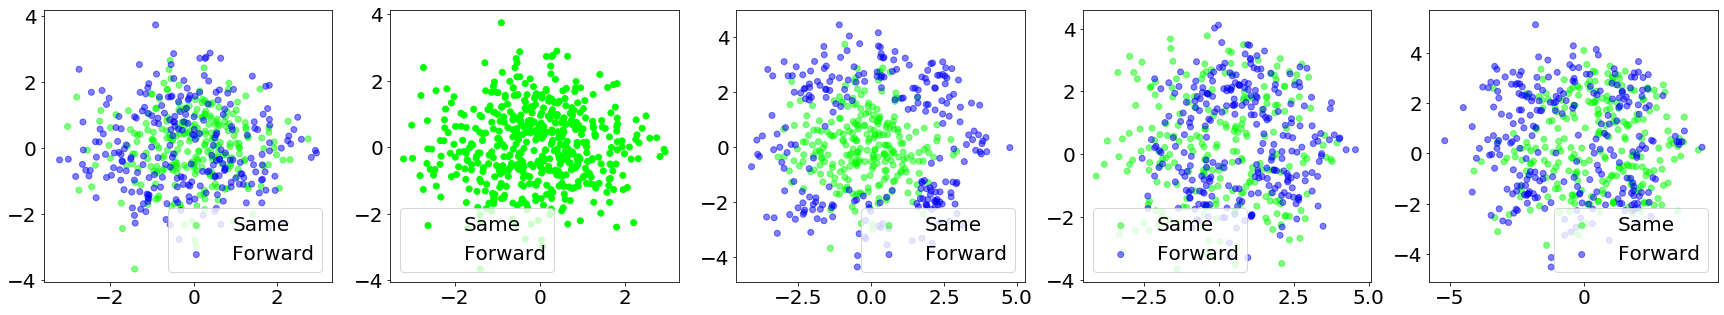

 10%|█         | 1017/10000 [03:30<31:03,  4.82it/s]

Early stopping on 1017


In [8]:
print_info_ = 100
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)
best_elbo = -float("inf")

def compute_loss(q_new, p_new, q_old, p_old, sum_log_alpha, sum_log_jac):
#     pdb.set_trace()
    log_p = target.get_logdensity(z=q_new) + args.std_normal.log_prob(p_new).sum(1)
    log_r = -args.K * torch_log_2
    log_m = args.std_normal.log_prob(q_old).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jacobian + sum_log_alpha
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full.detach().mean().item(), grad_elbo

if args.step_conditioning == 'fixed':
    cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]

iterator = tqdm(range(args.num_batches))
cur_tolerance = 0
for batch_num in iterator:
    plt.close()
    if args.step_conditioning == 'free':
        cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]
        
    # sample initial q and p
    q_old = args.std_normal.sample((args.train_batch_size, args.z_dim)).requires_grad_(True)
    p_old = args.std_normal.sample((args.train_batch_size, args.z_dim))
    
    # prepare tensors for auxilary stuff
    sum_log_alpha = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
    sum_log_jacobian = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
    
    q = q_old
    p = p_old
    if (batch_num) % print_info_ == 0:
        array_z = []
        array_directions = []
        array_alpha = []
    # run training cycle
    for k in range(args.K):
        q, p, log_jac, current_log_alphas, directions = transitions[k].make_transition(q_old=q,
                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
        if (batch_num) % print_info_ == 0:
            print('On batch number {} and on k = {} we have for 0: {} and for +1: {}'.format(batch_num, k + 1,
                                                        (directions==0.).to(float).mean(), (directions==1.).to(float).mean()))
            print('Step size for {}-th transition is {}'.format(k, transitions[k].gamma.detach().exp()))
            print('Alpha (ref) for {}-th transition is {}'.format(k, torch.sigmoid(transitions[k].alpha_logit.detach())))
        sum_log_alpha = sum_log_alpha + current_log_alphas
        sum_log_jacobian = sum_log_jacobian + log_jac
        if (batch_num) % print_info_ == 0:
            array_z.append(q.detach())
            array_directions.append(directions.detach())
            array_alpha.append(current_log_alphas.detach())
    elbo_full, grad_elbo = compute_loss(q_new=q, p_new=p, q_old=q_old, p_old=p_old, sum_log_jac=sum_log_jacobian,
                                            sum_log_alpha=sum_log_alpha)
    if (batch_num ) % print_info_ == 0:
        plt.scatter(q.cpu().detach()[:, 0], q.cpu().detach()[:, 1])
        plt.show();
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print('Current lr: ', current_lr)
        print('On batch number {} ELBO is {}'.format(batch_num, elbo_full))
        print('On batch number {} Best ELBO is {}'.format(batch_num, best_elbo))
        
        fig, ax = plt.subplots(ncols=args.K, figsize=(30, 5))
        label = ['Same', 'Forward']
        for kk in range(args.K):
            for d in [0., 1.]:
                z_c = array_z[kk][array_directions[kk]==d]
                alpha_c = array_alpha[kk][array_directions[kk]==d].cpu().exp().numpy()
                color = np.zeros((z_c.shape[0], 4))
                color[:, 3] = alpha_c
                color[:, int(d + 1)] = 1.
                ax[kk].scatter(z_c[:, 0].cpu().numpy(), z_c[:, 1].cpu().numpy(), color=color, label=label[int(d)])
                ax[kk].legend()
        plt.show();
    (-grad_elbo).backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(elbo_full)

    if np.isnan(elbo_full):
        print('NAN appeared!')
        raise ValueError

    if elbo_full > best_elbo:
        best_elbo = elbo_full
        our_kernel.load_state_dict(transitions.state_dict())
        cur_tolerance = 0
    else:
        cur_tolerance += 1
        if cur_tolerance >= args.early_stopping_tolerance:
            print('Early stopping on {}'.format(batch_num))
            iterator.close()
            break

In [9]:
# our_kernel = transitions
for p in our_kernel.parameters():
    p.requires_grad_(False)

In [10]:
# args.n_steps = args.K # how many samples to use
# args.n_warmup = 0 # num of first samples to refuse

# args.n_chains = 1000 # how many chains to model

# q_init = args.std_normal.sample((args.n_chains, args.z_dim))
# p_init = args.std_normal.sample((args.n_chains, args.z_dim))

In [ ]:
q_new = q_init
p_new = p_init

print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup // args.K))
for i in iterator:
    q_new = q_new.detach().requires_grad_(True)
    p_new = p_new.detach().requires_grad_(True)
    for k in range(args.K):
        if args.step_conditioning == 'free':
            cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]
        q_new, p_new, _, _, _ = our_kernel[k].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
                                                                   k=cond_vectors[k])
iterator.close()
    
samples_our = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)
print("Now we are sampling!")

iterator = tqdm(range(args.n_steps // args.K))
for i in iterator:
    q_new = q_new.detach().requires_grad_(True)
    p_new = p_new.detach().requires_grad_(True)
    for k in range(args.K):
        if args.step_conditioning == 'free':
            cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]
        q_new, p_new, _, _, a = our_kernel[k].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
                                                                       k=cond_vectors[k])
        samples_our[i] = q_new.detach()
iterator.close()

  0%|          | 1/200 [00:00<00:25,  7.82it/s]

Now we are running warmup!


  0%|          | 1/200 [00:00<00:26,  7.37it/s]

Now we are sampling!


 62%|██████▏   | 124/200 [00:17<00:10,  7.26it/s]

In [ ]:
limit = 20
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC our')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_our[:, chain_num, 0].cpu(), samples_our[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)